In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Dark2_7
import xarray as xr
import seaborn as sns
import copy
%matplotlib inline

import os
os.environ['PROJ_LIB'] = '/Users/hujun/.pyenv/versions/anaconda3-5.0.1/share/proj'
from mpl_toolkits.basemap import Basemap,addcyclic,shiftgrid

In [2]:
plt.style.use('junhu')

In [3]:
#read SPEEDY-IER data
#modern
sp1 = xr.open_dataset('/Users/hujun/Dropbox/RCP85/attmB20_1974-2013.nc')
#future
sp2 = xr.open_dataset('/Users/hujun/Dropbox/RCP85/attmB23_2074-2113.nc')

In [4]:
# coordinates of SPEEDY-IER
lat_sp=sp1.lat
lon_sp=sp1.lon
lev_sp=sp1.lev

In [5]:
lev_sp

<xarray.DataArray 'lev' (lev: 8)>
array([925., 850., 700., 500., 300., 200., 100.,  30.])
Coordinates:
  * lev      (lev) float64 925.0 850.0 700.0 500.0 300.0 200.0 100.0 30.0
Attributes:
    long_name:  generic
    units:      level
    axis:       Z

In [6]:
# coordinates of iCAM5
dr='/Users/hujun/Dropbox/model_complexity/CAM5_Modern_RCP85/'

lon0_cam=np.load(dr+'CAM5_lons.npy')
lat0_cam=np.load(dr+'CAM5_lats.npy')
lev_cam=np.load(dr+'CAM5_levs.npy')

lat_cam=lat0_cam[31:161]
lon_cam=lon0_cam

## Precipitation isotopes

In [9]:
# get precipitation d18O
# SPEEDY-IER
def read_d18o(ds):
    o16_large = ds.prlh2o
    o16_conv = ds.prch2o
    o18_large = ds.prlh218o
    o18_conv = ds.prch218o

    o16_speedy = o16_large + o16_conv
    o18_speedy = o18_large + o18_conv

    d18o_speedy = (o18_speedy/o16_speedy-1)*1000
    d18o_mean = d18o_speedy.mean(dim='time')
    return d18o_mean

prd18o1_sp = read_d18o(sp1)
prd18o2_sp = read_d18o(sp2)

prd18o_diff_sp = prd18o2_sp - prd18o1_sp

In [10]:
# iCAM5
O16E=np.load(dr+'CAM_PRECIP_TOTAL.npy')[0:-2,31:161,:]
O16C=np.load(dr+'CAM_PRECIP_TOTAL_future.npy')[0:-2,31:161,:]

O18E=np.load(dr+'CAM_PRECIP18_TOTAL_modern.npy')[0:-2,31:161,:]
O18C=np.load(dr+'CAM_PRECIP18_TOTAL_future.npy')[0:-2,31:161,:]

d18oE=(O18E/O16E-1)*1000.
d18oC=(O18C/O16C-1)*1000.

prd18o_diff_cam = np.average(d18oC,axis=0) - np.average(d18oE,axis=0)

/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


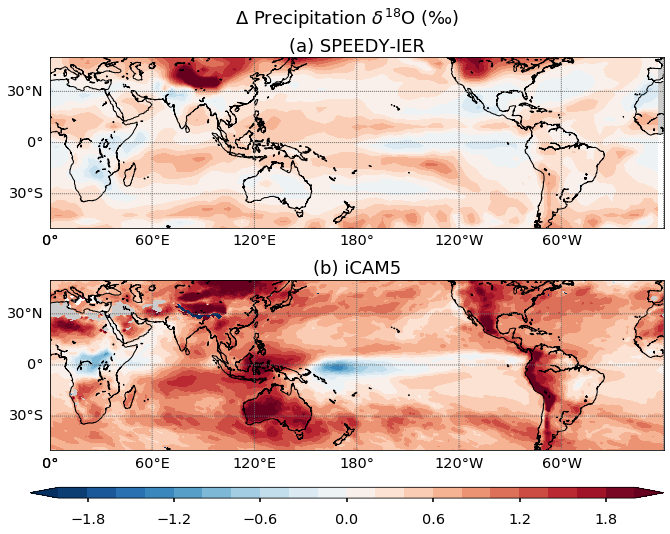

In [12]:
map = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=50,llcrnrlon=0,urcrnrlon=360,lat_ts=20,resolution='l')
fig=plt.figure(figsize=(11,7.5))
fig.suptitle(u'$\Delta$ Precipitation $\delta^{18}$O (\u2030)',fontsize=18,y=0.96)

ax1=fig.add_subplot(211)
ax1.set_title('(a) SPEEDY-IER')
map.fillcontinents(zorder=0)
map.drawcoastlines()
map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,1],color='DimGray',fontsize=14.5)
map.drawparallels(np.arange(-60,60,30),labels=[1,0,0,0],color='DimGray',fontsize=14.5)

lons, lats = np.meshgrid(lon_sp.values, lat_sp.values)
x1,y1 = map(lons, lats)
clevs=np.linspace(-2,2,21)
cs=map.contourf(x1,y1,prd18o_diff_sp,clevs,cmap=plt.cm.RdBu_r,extend='both')

ax2=fig.add_subplot(212)
ax2.set_title('(b) iCAM5')
map.fillcontinents(zorder=0)
map.drawcoastlines()
map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,1],color='DimGray',fontsize=14.5)
map.drawparallels(np.arange(-60,60,30),labels=[1,0,0,0],color='DimGray',fontsize=14.5)

lons, lats = np.meshgrid(lon_cam, lat_cam)
x1,y1 = map(lons, lats)
cs=map.contourf(x1,y1,prd18o_diff_cam,clevs,cmap=plt.cm.RdBu_r,extend='both')

cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cbar = fig.colorbar(cs, cax=cb_ax, orientation='horizontal')
#cbar.set_label('(mm/day)', labelpad=-16, x=0.95,y=-0.6, rotation=0)

fig.savefig('precip_diff_d18O.pdf',dpi=300,bbox_inches='tight')

## Water vapor isotopes

In [14]:
# water vapor dD
# SPEEDY-IER
qdo1_sp = (sp1.hdo/sp1.h2o-1)*1000
qdo2_sp = (sp2.hdo/sp2.h2o-1)*1000
qdo_diff_sp = qdo2_sp.mean(dim='time')-qdo1_sp.mean(dim='time')

/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [15]:
# iCAM5
Q=np.load(dr+'CAM_VARS_H216OV_modern.npy')[0:-2,:,31:161,:]
QE=np.load(dr+'CAM_VARS_H216OV_2100.npy')[0:-2,:,31:161,:]

D=np.load(dr+'CAM_VARS_HDOV_modern.npy')[0:-2,:,31:161,:]
DE=np.load(dr+'CAM_VARS_HDOV_2100.npy')[0:-2,:,31:161,:]

# water vapor dD
qdo1_cam=(D/Q-1)*1000
qdo2_cam=(DE/QE-1)*1000

qdo_diff_cam = np.average(qdo2_cam,axis=0)-np.average(qdo1_cam,axis=0)

In [18]:
# tropical mean dD
# SPEEDY-IER
qdo_tropics1_sp = qdo1_sp.sel(lat=slice(-10,10)).mean(dim=['time','lat'])
qdo_tropics2_sp = qdo2_sp.sel(lat=slice(-10,10)).mean(dim=['time','lat'])
qdo_tropics_diff_sp = qdo_tropics2_sp - qdo_tropics1_sp

/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [19]:
# iCAM5
qdo_tropics1_cam=np.average(qdo1_cam[:,:,53:77,:],axis=(0,2))
qdo_tropics2_cam=np.average(qdo2_cam[:,:,53:77,:],axis=(0,2))
qdo_tropics_diff_cam = qdo_tropics2_cam - qdo_tropics1_cam

In [20]:
def latlonformat(lats,flag):
    '''
    Plot degree symbol and W/E/S/N for longitude/latitude
    lats: list of latitude or longitude
    flag: whether the input is latitude or longitude
        options: 'lat' and 'lon'
    Output:
    A list of lat/lon labels
    '''
    label_list=[]
    if flag=='lat':
        for lat in lats:
            if lat<0:
                label=str(int(-lat))+u'\u00B0S'
            elif lat>0:
                label=str(int(lat))+u'\u00B0N'
            else:
                label=str(int(lat))
            label_list.append(label)
    elif flag=='lon':
        for lat in lats:
            if lat>0 and lat<180:
                label=str(int(lat))+u'\u00B0E'
            elif lat>180 and lat<=360:
                label=str(int(360-lat))+u'\u00B0W'
            elif lat<0:
                label=str(int(-lat))+u'\u00B0W'
            else:
                label=str(int(lat))
            label_list.append(label)
    
    return label_list

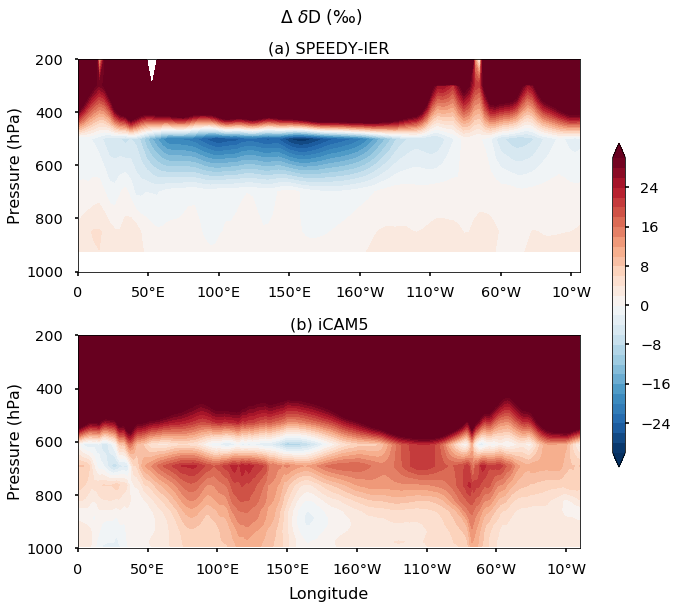

In [22]:
fig, ax = plt.subplots(2,figsize=(9,9))
fig.suptitle(u'$\Delta$ $\delta$D (\u2030)',fontsize=17,y=0.96)
for i in range(2):
    clevs=np.linspace(-30,30,31)
    if i==0:
        cs=ax[i].contourf(lon_sp,lev_sp,qdo_tropics_diff_sp,clevs,cmap=plt.cm.RdBu_r,extend='both')
        ax[i].set_title('(a) SPEEDY-IER',fontsize=16)
    else:
        cs=ax[i].contourf(lon_cam,lev_cam,qdo_tropics_diff_cam,clevs,cmap=plt.cm.RdBu_r,extend='both')
        ax[i].set_title('(b) iCAM5',fontsize=16)

    a=ax[i].get_xticks().tolist()
    ax[i].set_xticklabels(latlonformat(a,'lon'))
    ax[i].set_ylim(200,1000)
    ax[i].set_ylabel('Pressure (hPa)')
    if i==1:
        ax[i].set_xlabel('Longitude',labelpad=10)
    ax[i].invert_yaxis()

fig.subplots_adjust(hspace=0.3)
cb_ax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(cs, cax=cb_ax,orientation='vertical')
#cbar.set_label('(Pa/s)', labelpad=-30, y=1.02, rotation=0)

fig.savefig('dD_tropics_diff.pdf',dpi=300,bbox_inches='tight')

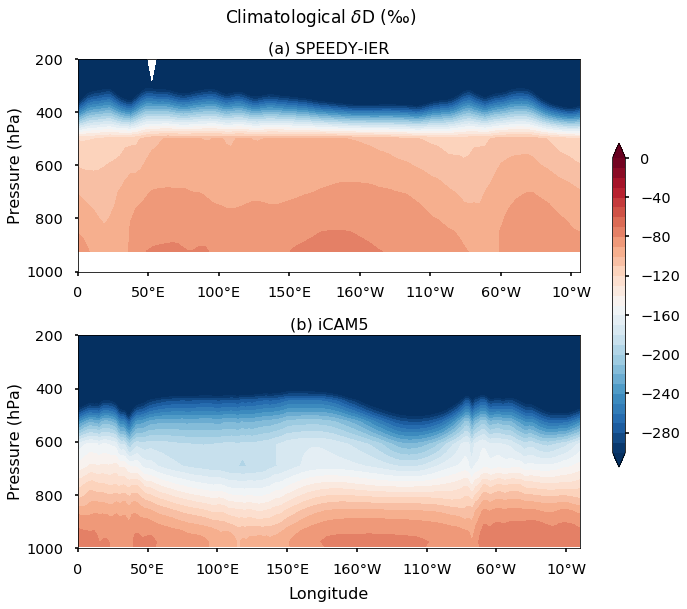

In [69]:
fig, ax = plt.subplots(2,figsize=(9,9))
fig.suptitle(u'Climatological $\delta$D (\u2030)',fontsize=17,y=0.96)
for i in range(2):
    clevs=np.linspace(-300,0,31)
    if i==0:
        cs=ax[i].contourf(lon_sp,lev_sp,qdo_tropics1_sp,clevs,cmap=plt.cm.RdBu_r,extend='both')
        ax[i].set_title('(a) SPEEDY-IER',fontsize=16)
    else:
        cs=ax[i].contourf(lon_cam,lev_cam,qdo_tropics1_cam,clevs,cmap=plt.cm.RdBu_r,extend='both')
        ax[i].set_title('(b) iCAM5',fontsize=16)

    a=ax[i].get_xticks().tolist()
    ax[i].set_xticklabels(latlonformat(a,'lon'))
    ax[i].set_ylim(200,1000)
    ax[i].set_ylabel('Pressure (hPa)')
    if i==1:
        ax[i].set_xlabel('Longitude',labelpad=10)
    ax[i].invert_yaxis()

fig.subplots_adjust(hspace=0.3)
cb_ax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(cs, cax=cb_ax,orientation='vertical')
#cbar.set_label('(Pa/s)', labelpad=-30, y=1.02, rotation=0)

fig.savefig('dD_tropics_climate.pdf',dpi=300,bbox_inches='tight')

## Rayleigh model

In [50]:
#Step1: saturated vapor pressure
def qsat_func(temp,pressure):
    '''pressure in hPa'''
    Rv= 8.3144598 #J/mol K
    Lv= 2.500e6 # J/kg
    epsilon=0.622 
    Mw = 18.016 # molecular weight of water
    es = 610.78 * np.exp((17.27 * (temp-273.15)) / ((temp-273.15) + 237.3))
    qs = epsilon*es/pressure/100
    return qs

# Step2: calculate the temperature-dependent equilibrium fractionation factor
# for D
def alpha_liq_func(temp):
    a_D   = 24.844e+3
    b_D   = -76.248
    c_D   =  52.612e-3
    alpha = a_D/((temp)*(temp)) + b_D/(temp) + c_D
    alpha_liq = np.exp(alpha)
    return alpha_liq

def rayleigh_model(temp_mean,qdo_mean,lev):
    '''Rayleigh distillation model:
    assuming moist adiabatic heating profile and 
    moisture moves out once reaching saturation
    
    '''
    qsat=np.zeros(temp_mean.shape)
    for k in range(len(lev)):
        qsat[k,:,:]=qsat_func(temp_mean[k,:,:],lev[k])
    
    alpha_liq = alpha_liq_func(temp_mean)
    
    dD_ray=np.zeros(temp_mean.shape)
    
    if lev[1]<lev[0]:
        for k in range(len(lev)):
            if k==0:
                dD_ray[k,:,:]=qdo_mean[0,:,:]
            else:
                f=qsat[k,:,:]/qsat[k-1,:,:]
                dD_0=dD_ray[k-1,:,:]
                dD_ray[k,:,:] = (dD_0+1000)*np.power(f,alpha_liq[k,:,:]-1)-1000
    else:
        for k in range(len(lev)-1,0,-1):
            if k==len(lev)-1:
                f=qsat[-2,:,:]/qsat[-1,:,:]
                dD_ray[k,:,:]=qdo_mean[-1,:,:]
            else:
                f=qsat[k,:,:]/qsat[k+1,:,:]
                dD_0=dD_ray[k+1,:,:]
                dD_ray[k,:,:] = (dD_0+1000)*f**(alpha_liq[k,:,:]-1)-1000
        
    return dD_ray

In [51]:
# SPEEDY-IER
temp_mean1_sp = sp1.temp.mean(dim='time')
temp_mean2_sp = sp2.temp.mean(dim='time')
qdo_mean1_sp = qdo1_sp.mean(dim='time')
qdo_mean2_sp = qdo2_sp.mean(dim='time')

dD_ray1_sp=rayleigh_model(temp_mean1_sp,qdo_mean1_sp,lev_sp)
dD_ray2_sp=rayleigh_model(temp_mean2_sp,qdo_mean2_sp,lev_sp)

/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [54]:
# iCAM5
# temperature
TE=np.load(dr+'CAM_VARS_T_2100.npy')[0:-2,:,31:161,:]
TC=np.load(dr+'CAM_VARS_T_modern.npy')[0:-2,:,31:161,:]

TC_mean = np.average(TC,axis=0)
TE_mean = np.average(TE,axis=0)

#water vapor dD
qdo_mean1_cam = np.average(qdo1_cam,axis=0)
qdo_mean2_cam = np.average(qdo2_cam,axis=0)

dD_ray1_cam = rayleigh_model(TC_mean,qdo_mean1_cam,lev_cam)
dD_ray2_cam = rayleigh_model(TE_mean,qdo_mean2_cam,lev_cam)

In [66]:
# change of Rayleigh model dD
dD_ray_diff_sp = dD_ray2_sp - dD_ray1_sp
dD_ray_diff_cam = dD_ray2_cam - dD_ray1_cam

In [67]:
# residual (dynamic term)
dD_tray1_sp = qdo_mean1_sp - dD_ray1_sp
dD_tray2_sp = qdo_mean2_sp - dD_ray2_sp

dD_tray1_cam = qdo_mean1_cam - dD_ray1_cam
dD_tray2_cam = qdo_mean2_cam - dD_ray2_cam
# change
dD_tray_diff_sp = dD_tray2_sp - dD_tray1_sp
dD_tray_diff_cam = dD_tray2_cam - dD_tray1_cam

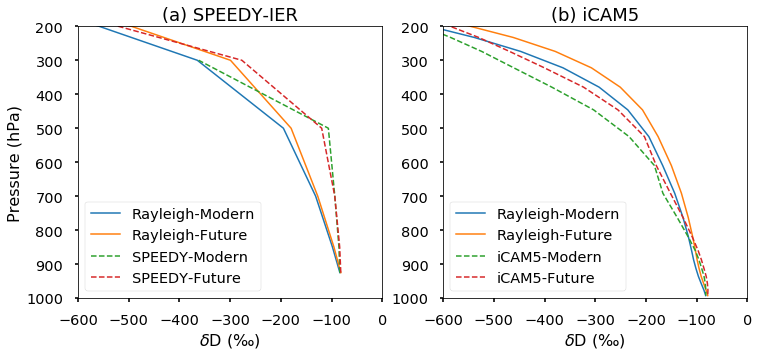

In [70]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
for i in range(2):
    if i==0:
        ax[i].set_title('(a) SPEEDY-IER')
        ax[i].plot(np.average(dD_ray1_sp[:,21:27,:],axis=(1,2)),lev_sp,label='Rayleigh-Modern')
        ax[i].plot(np.average(dD_ray2_sp[:,21:27,:],axis=(1,2)),lev_sp,label='Rayleigh-Future')
        ax[i].plot(np.average(qdo_mean1_sp[:,21:27,:],axis=(1,2)),lev_sp,linestyle='dashed',label='SPEEDY-Modern')
        ax[i].plot(np.average(qdo_mean2_sp[:,21:27,:],axis=(1,2)),lev_sp,linestyle='dashed',label='SPEEDY-Future')
    else:
        ax[i].set_title('(b) iCAM5')
        ax[i].plot(np.average(dD_ray1_cam[:,53:77,:],axis=(1,2)),lev_cam,label='Rayleigh-Modern')
        ax[i].plot(np.average(dD_ray2_cam[:,53:77,:],axis=(1,2)),lev_cam,label='Rayleigh-Future')
        ax[i].plot(np.average(qdo_mean1_cam[:,53:77,:],axis=(1,2)),lev_cam,linestyle='dashed',label='iCAM5-Modern')
        ax[i].plot(np.average(qdo_mean2_cam[:,53:77,:],axis=(1,2)),lev_cam,linestyle='dashed',label='iCAM5-Future')
    ax[i].set_ylim(1000,200)
    ax[i].set_xlim(-600,0)

    ax[i].set_xlabel(u'$\delta$D (\u2030)')
    if i==0:
        ax[i].set_ylabel('Pressure (hPa)')
    ax[i].legend()

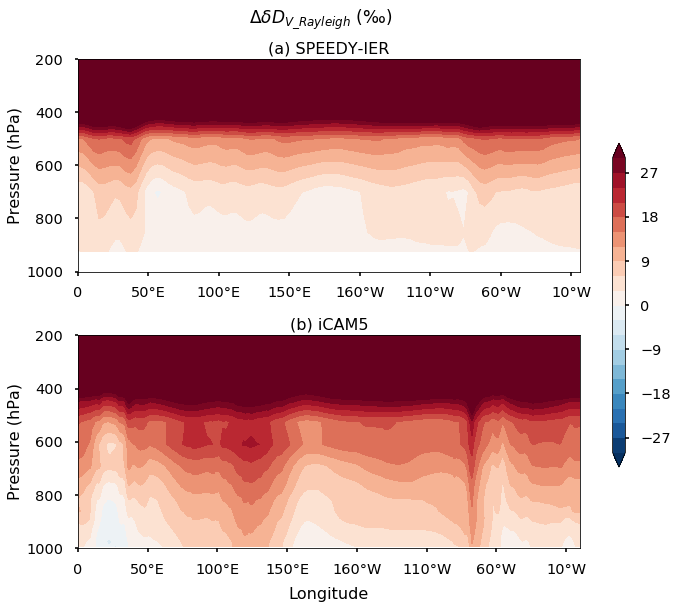

In [79]:
fig, ax = plt.subplots(2,figsize=(9,9))
fig.suptitle(u'$\Delta \delta{D}_{V\_Rayleigh}$ (\u2030)',fontsize=17,y=0.96)
for i in range(2):
    
    clevs=np.linspace(-30,30,21)

    if i==0:
        cs=ax[i].contourf(lon_sp,lev_sp,np.average(dD_ray_diff_sp[:,21:27,:],axis=1),clevs,cmap=plt.cm.RdBu_r,extend='both')
        ax[i].set_title('(a) SPEEDY-IER',fontsize=16)
    else:
        cs=ax[i].contourf(lon_cam,lev_cam,np.average(dD_ray_diff_cam[:,53:77,:],axis=1),clevs,cmap=plt.cm.RdBu_r,extend='both')
        ax[i].set_title('(b) iCAM5',fontsize=16)
    #cbar = fig.colorbar(cs)
    #cbar.set_label('(Pa/s)', labelpad=-30, y=1.08, rotation=0)

    a=ax[i].get_xticks().tolist()
    ax[i].set_xticklabels(latlonformat(a,'lon'))
    ax[i].set_ylim(200,1000)
    ax[i].set_ylabel('Pressure (hPa)')
    if i==1:
        ax[i].set_xlabel('Longitude',labelpad=10)
    ax[i].invert_yaxis()

fig.subplots_adjust(hspace=0.3)
cb_ax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(cs, cax=cb_ax,orientation='vertical')

fig.savefig('dD_rayleigh_diff.pdf',dpi=300,bbox_inches='tight')

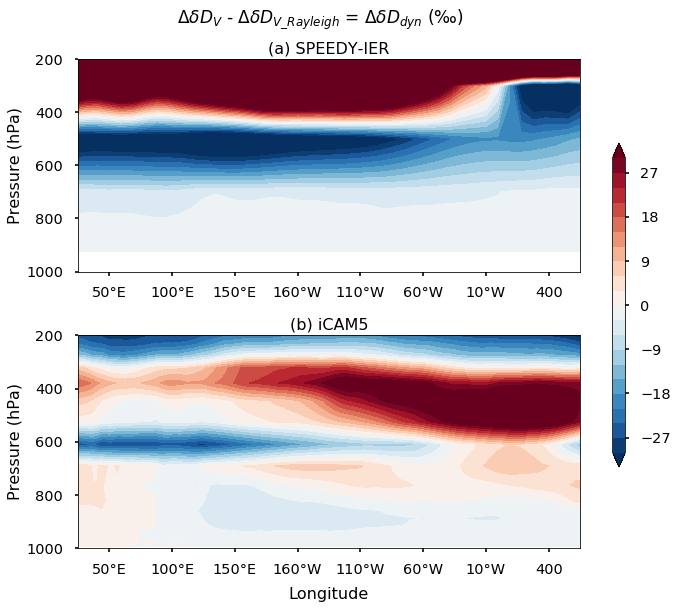

In [84]:
fig, ax = plt.subplots(2,figsize=(9,9))
fig.suptitle(u'$\Delta \delta{D}_{V}$ - $\Delta \delta{D}_{V\_Rayleigh}$ = $\Delta \delta{D}_{dyn}$ (\u2030)',fontsize=17,y=0.96)
for i in range(2):
    
    clevs=np.linspace(-30,30,21)

    if i==0:
        cs=ax[i].contourf(lon_sp,lev_sp,np.average(dD_tray_diff_sp[:,21:27,:],axis=1),clevs,cmap=plt.cm.RdBu_r,extend='both')
        ax[i].set_title('(a) SPEEDY-IER',fontsize=16)
    else:
        cs=ax[i].contourf(lon_cam,lev_cam,np.average(dD_tray_diff_cam[:,53:77,:],axis=1),clevs,cmap=plt.cm.RdBu_r,extend='both')
        ax[i].set_title('(b) iCAM5',fontsize=16)
    #cbar = fig.colorbar(cs)
    #cbar.set_label('(Pa/s)', labelpad=-30, y=1.08, rotation=0)

    a=ax[i].get_xticks().tolist()
    ax[i].set_xticklabels(latlonformat(a,'lon'))
    ax[i].set_ylim(200,1000)
    ax[i].set_xlim(110,270)
    ax[i].set_ylabel('Pressure (hPa)')
    if i==1:
        ax[i].set_xlabel('Longitude',labelpad=10)
    ax[i].invert_yaxis()

fig.subplots_adjust(hspace=0.3)
cb_ax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(cs, cax=cb_ax,orientation='vertical')

fig.savefig('dD_dyn_diff.pdf',dpi=300,bbox_inches='tight')

In [86]:
# interpolate dD_dyn to 600hPa for iCAM5
# to avoid the wierd vector plotting problem
import Ngl

P0=np.load(dr+'P0.npy')
PS=np.load(dr+'PS_2100.npy')[0:-2,31:161,:]

hyam=np.load(dr+'hyam.npy')
hyai=np.load(dr+'hyai.npy')
hybm=np.load(dr+'hybm.npy')
hybi=np.load(dr+'hybi.npy')

PS_mean = np.average(PS,axis=0)

P0mb=P0/100
intyp = 1
kxtrp = False

dD_tray_diff_cam_600 = Ngl.vinth2p(dD_tray_diff_cam,hyam,hybm,[600.],PS_mean,intyp,P0mb,1,kxtrp)

In [88]:
# interpolate dD_dyn to 600hPa for SPEEDY-IER
from scipy import interpolate

f = interpolate.interp1d(lev_sp,dD_tray_diff_sp,axis=0)
dD_tray_diff_sp_600 = f(600)

/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


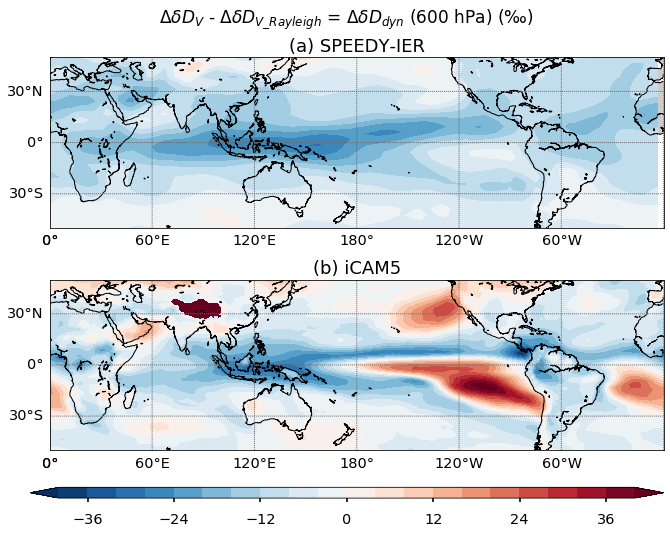

In [91]:
map = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=50,llcrnrlon=0,urcrnrlon=360,lat_ts=20,resolution='l')
fig=plt.figure(figsize=(11,7.5))
fig.suptitle(u'$\Delta \delta{D}_{V}$ - $\Delta \delta{D}_{V\_Rayleigh}$ = $\Delta \delta{D}_{dyn}$ (600 hPa) (\u2030)',fontsize=17,y=0.96)

ax1=fig.add_subplot(211)
ax1.set_title('(a) SPEEDY-IER')
map.fillcontinents(zorder=0)
map.drawcoastlines()
map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,1],color='DimGray',fontsize=14.5)
map.drawparallels(np.arange(-60,60,30),labels=[1,0,0,0],color='DimGray',fontsize=14.5)

lons, lats = np.meshgrid(lon_sp.values, lat_sp.values)
x1,y1 = map(lons, lats)
clevs=np.linspace(-40,40,21)
cs=map.contourf(x1,y1,dD_tray_diff_sp_600,clevs,cmap=plt.cm.RdBu_r,extend='both')

ax2=fig.add_subplot(212)
ax2.set_title('(b) iCAM5')
map.fillcontinents(zorder=0)
map.drawcoastlines()
map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,1],color='DimGray',fontsize=14.5)
map.drawparallels(np.arange(-60,60,30),labels=[1,0,0,0],color='DimGray',fontsize=14.5)

lons, lats = np.meshgrid(lon_cam, lat_cam)
x1,y1 = map(lons, lats)
cs=map.contourf(x1,y1,dD_tray_diff_cam_600[0,:,:],clevs,cmap=plt.cm.RdBu_r,extend='both')

cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cbar = fig.colorbar(cs, cax=cb_ax, orientation='horizontal')
#cbar.set_label('(mm/day)', labelpad=-16, x=0.95,y=-0.6, rotation=0)

fig.savefig('dD_dyn_diff_600.pdf',dpi=300,bbox_inches='tight')